In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.5 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, pipeline
import torch
from transformers import TrainingArguments, Trainer

In [ ]:
torch.cuda.empty_cache()

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/dataset/yelp_dataset_undersampled.pkl')

In [ ]:
df.sample(10)

,text,stars,length
2454810,My hubster found this place on the food networ...,5,237
1881035,"WOW! First visit to Plaza Mexico ever, and luc...",5,201
3503299,"Nice spot, someone recommended us going to try...",3,221
2878079,"Atmosphere: skews older, average age in bar ar...",2,227
1830201,tl;dr probably a great spot for St. Louis/MO t...,4,205
690243,So a friend and I were meeting for an imprompt...,5,403
3684531,"TERRIBLE, now! I've been here several times ye...",1,332
4517161,On your way back from Violet or up from Plaque...,4,375
1458367,So I made my way here for lunch yesterday sinc...,3,242
149156,"Ambience:\nPerfect, in my opinion. Uncluttered...",5,200


<Axes: ylabel='Frequency'>

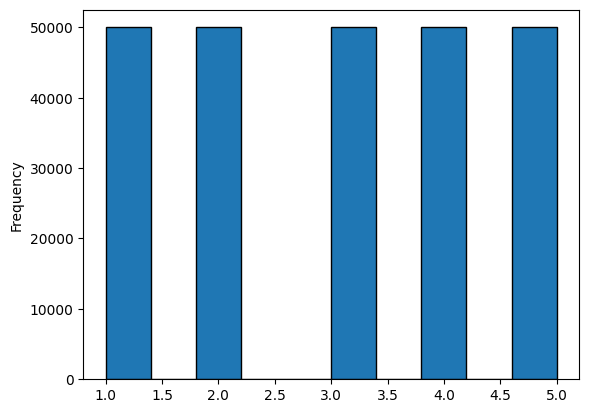

In [ ]:
df['stars'].plot(kind='hist', edgecolor='black')

In [ ]:
nMax = 500

res = df.groupby('stars').apply(lambda x: x.sample(n=min(nMax, len(x))))
pd.set_option('display.max_rows', 250)
print(res['stars'].value_counts())

1    500
2    500
3    500
4    500
5    500
Name: stars, dtype: int64


In [ ]:
df = res
df = df.reset_index(drop=True)

In [ ]:
df['stars'] = df['stars'] - 1

In [ ]:
df

,text,stars,length
0,Update to below's review: \n\nNext day. Yep. M...,0,261
1,I think one star is being very generous. The ...,0,305
2,So I was Super excited abt trying this place f...,0,286
3,"The food was amazing, unfortunately I value th...",0,270
4,Pancakes for lunch! Food was okay but horrible...,0,262
...,...,...,...
2495,This was perhaps the best meal we had during o...,4,339
2496,It's been a hot minute since my last Yelp revi...,4,297
2497,"Last night, six of us went to Desano Pizza for...",4,209
2498,Ordered lunch delivery on a busy Saturday whil...,4,210


In [ ]:
df.to_pickle('./drive/MyDrive/yelp_dataset_2500.pkl')

In [ ]:
dataX = df['text']
dataY = df['stars']
dataX.head(5), dataY.head(5)

(0    Update to below's review: \n\nNext day. Yep. M...
 1    I think one star is being very generous.  The ...
 2    So I was Super excited abt trying this place f...
 3    The food was amazing, unfortunately I value th...
 4    Pancakes for lunch! Food was okay but horrible...
 Name: text, dtype: object,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: stars, dtype: int64)

In [ ]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
raw_train_df = pd.concat([x_train, y_train], axis=1)
raw_test_df = pd.concat([x_test, y_test], axis=1)
raw_val_df = pd.concat([x_val, y_val], axis=1)

In [ ]:
raw_train_ds = Dataset.from_pandas(raw_train_df)
raw_test_ds = Dataset.from_pandas(raw_test_df)
raw_val_ds = Dataset.from_pandas(raw_val_df)

In [ ]:
print(raw_train_ds, raw_val_ds, raw_test_ds)

Dataset({
    features: ['text', 'stars', '__index_level_0__'],
    num_rows: 2000
}) Dataset({
    features: ['text', 'stars', '__index_level_0__'],
    num_rows: 250
}) Dataset({
    features: ['text', 'stars', '__index_level_0__'],
    num_rows: 250
})


In [ ]:
BASE_MODEL = "allenai/longformer-base-4096"
LEARNING_RATE = 2e-5
MAX_LENGTH = 1024
BATCH_SIZE = 4
EPOCHS = 5

id2label = {k:k for k in range(5)}
label2id = {k:k for k in range(5)}

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias'

In [ ]:
ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}

def preprocess_function(examples):
    label = examples["stars"]
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)
    examples["label"] = label
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "stars"])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-20-75db7450f822>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../models/yelp-longformer-classification",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [ ]:
from transformers import Trainer

torch.manual_seed(42)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.623900,1.511283,0.620000
2,0.629600,1.583978,0.692000
3,0.394100,1.622592,0.722000
4,0.169900,1.601794,0.740000
5,0.089700,1.678891,0.714000


TrainOutput(global_step=2500, training_loss=0.3814615600585938, metrics={'train_runtime': 1212.5952, 'train_samples_per_second': 8.247, 'train_steps_per_second': 2.062, 'total_flos': 6568657858560000.0, 'train_loss': 0.3814615600585938, 'epoch': 5.0})

In [ ]:
trainer.eval_dataset=ds["test"]
trainer.evaluate()


{'eval_loss': 0.6788907051086426,
 'eval_accuracy': 0.722,
 'eval_runtime': 7.9046,
 'eval_samples_per_second': 31.627,
 'eval_steps_per_second': 7.97,
 'epoch': 5.0}
    


In [ ]:
input_texts = ["This restaurant is amazing and has the best soup",
               "This restaurant is just okay, can be better. But the drinks are good",
               "Best sushi I've ever had in Tokyo",
               "The drinks are decent. I really like the dumplings",
               "The price is too expensive and the food quality is bad. The waiters were really nice to me, though."
              ]

# Encode the text
encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=1024, return_tensors="pt").to("cuda")

# Call the model to predict under the format of logits of 5 classes
logits = model(**encoded).logits

# Get the class
torch.argmax(logits, axis=1)

tensor([4, 2, 4, 3, 1], device='cuda:0')

In [ ]:
#trainer.save_model('./drive/MyDrive/yelp-longformer-500')

In [ ]:
#tokenizer.save_pretrained("./drive/MyDrive/yelp-longformer-tokenizer-500")

In [ ]:
predicted = trainer.predict(ds["test"])

In [ ]:
predicted

PredictionOutput(predictions=array([[-2.1938603 , -2.363472  ,  7.220684  , -2.1980517 , -1.1404881 ],
       [-2.4102166 , -0.5842706 ,  6.97968   , -2.9443543 , -1.7069865 ],
       [ 7.1018114 , -1.3124312 , -1.4727148 , -2.2494712 , -2.3855133 ],
       ...,
       [-1.7330593 , -1.9689478 , -0.62024194, -2.039436  ,  7.450509  ],
       [-1.7783492 , -1.8433281 , -1.7656637 ,  7.4456882 , -1.5240179 ],
       [-2.1808784 , -2.2117167 , -0.81020266, -1.2296453 ,  7.663249  ]],
      dtype=float32), label_ids=array([2, 2, 1, 1, 2, 3, 1, 2, 2, 1, 3, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2, 0,
       2, 4, 0, 4, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 3, 2, 0,
       1, 1, 2, 0, 4, 1, 3, 0, 1, 0, 1, 2, 2, 0, 3, 4, 3, 3, 3, 1, 3, 1,
       2, 3, 3, 3, 1, 1, 1, 1, 1, 2, 4, 4, 2, 2, 0, 3, 4, 4, 4, 3, 3, 3,
       1, 3, 0, 3, 2, 3, 4, 0, 4, 3, 3, 3, 3, 1, 1, 2, 2, 2, 3, 0, 2, 4,
       0, 3, 4, 2, 0, 2, 3, 3, 3, 4, 4, 0, 4, 0, 0, 3, 2, 4, 1, 3, 2, 2,
       4, 3, 0, 2, 2, 2, 2, 2, 3, 0, 3, 2, 3

In [ ]:
predicted_array = np.argmax(predicted.predictions, axis=1)
predicted_array

array([2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2, 0,
       2, 4, 0, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 0, 2, 3, 0,
       2, 1, 2, 1, 4, 2, 3, 1, 1, 0, 1, 2, 2, 1, 3, 3, 3, 4, 3, 1, 4, 0,
       2, 3, 4, 2, 1, 0, 1, 1, 1, 2, 4, 4, 1, 2, 1, 3, 4, 4, 3, 3, 3, 3,
       1, 3, 0, 2, 2, 3, 4, 0, 2, 3, 3, 2, 3, 0, 1, 2, 3, 1, 3, 0, 3, 4,
       1, 3, 3, 2, 0, 1, 3, 3, 3, 3, 4, 0, 4, 0, 0, 2, 3, 4, 1, 3, 2, 2,
       4, 3, 0, 2, 2, 2, 1, 3, 2, 0, 1, 3, 3, 3, 3, 1, 1, 3, 2, 4, 4, 2,
       2, 1, 3, 1, 3, 1, 3, 0, 1, 2, 4, 0, 4, 2, 0, 1, 2, 3, 2, 3, 1, 3,
       1, 4, 2, 3, 4, 3, 1, 2, 0, 1, 1, 2, 1, 0, 4, 1, 4, 4, 0, 1, 2, 4,
       1, 1, 4, 3, 2, 4, 2, 2, 1, 0, 2, 1, 1, 0, 1, 2, 1, 3, 2, 1, 3, 4,
       1, 0, 3, 2, 1, 1, 4, 0, 4, 0, 1, 1, 3, 4, 4, 4, 3, 3, 4, 2, 3, 1,
       3, 1, 1, 1, 0, 4, 3, 4])

In [ ]:
array2 = np.array([2, 2, 1, 1, 2, 3, 1, 2, 2, 1, 3, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2, 0,
       2, 4, 0, 4, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 1, 1, 0, 2, 3, 0,
       2, 1, 2, 1, 4, 2, 3, 1, 1, 0, 1, 2, 2, 1, 3, 3, 3, 4, 3, 1, 4, 0,
       2, 3, 4, 2, 1, 0, 1, 1, 1, 2, 4, 4, 1, 2, 1, 3, 4, 4, 3, 3, 3, 3,
       1, 3, 0, 2, 2, 3, 4, 0, 2, 3, 3, 2, 3, 0, 1, 2, 3, 1, 3, 0, 3, 4,
       1, 3, 3, 2, 0, 1, 3, 3, 3, 3, 4, 0, 4, 0, 0, 2, 3, 4, 1, 3, 2, 2,
       4, 3, 0, 2, 2, 2, 1, 3, 2, 0, 1, 3, 3, 3, 3, 1, 1, 3, 2, 4, 4, 2,
       2, 1, 3, 1, 3, 1, 3, 0, 1, 2, 4, 0, 4, 2, 0, 1, 2, 3, 2, 3, 1, 3,
       1, 4, 2, 3, 4, 3, 1, 2, 0, 1, 1, 2, 1, 0, 4, 1, 4, 4, 0, 1, 2, 4,
       1, 1, 4, 3, 2, 4, 2, 2, 1, 0, 2, 1, 1, 0, 1, 2, 1, 3, 2, 1, 3, 4,
       1, 1, 2, 1, 2, 0, 4, 0, 4, 1, 0, 1, 4, 4, 3, 4, 1, 4, 4, 3, 3, 1,
       3, 0, 0, 1, 0, 4, 3, 3])

In [ ]:
actual = np.array(raw_test_df['stars'])
actual

array([2, 2, 1, 1, 2, 3, 1, 2, 2, 1, 3, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2, 0,
       2, 4, 0, 4, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 3, 2, 0,
       1, 1, 2, 0, 4, 1, 3, 0, 1, 0, 1, 2, 2, 0, 3, 4, 3, 3, 3, 1, 3, 1,
       2, 3, 3, 3, 1, 1, 1, 1, 1, 2, 4, 4, 2, 2, 0, 3, 4, 4, 4, 3, 3, 3,
       1, 3, 0, 3, 2, 3, 4, 0, 4, 3, 3, 3, 3, 1, 1, 2, 2, 2, 3, 0, 2, 4,
       0, 3, 4, 2, 0, 2, 3, 3, 3, 4, 4, 0, 4, 0, 0, 3, 2, 4, 1, 3, 2, 2,
       4, 3, 0, 2, 2, 2, 2, 2, 3, 0, 3, 2, 3, 4, 3, 1, 1, 4, 3, 4, 4, 2,
       2, 0, 4, 1, 3, 0, 3, 2, 1, 2, 3, 0, 4, 3, 0, 1, 2, 3, 2, 3, 2, 2,
       1, 4, 2, 3, 3, 3, 1, 2, 1, 0, 1, 1, 2, 0, 3, 1, 3, 4, 0, 1, 4, 4,
       1, 1, 4, 3, 3, 4, 2, 2, 0, 1, 3, 1, 1, 1, 0, 1, 0, 3, 1, 0, 3, 4,
       1, 1, 2, 1, 2, 0, 4, 0, 4, 1, 0, 1, 4, 4, 3, 4, 1, 4, 4, 3, 3, 1,
       3, 0, 0, 1, 0, 4, 3, 3])

In [ ]:
len(array2)

250

In [ ]:
from sklearn.metrics import confusion_matrix
yelp_confusion_matrix = confusion_matrix(actual, array2, normalize='true')
yelp_confusion_matrix

array([[0.66666667, 0.33333333, 0.        , 0.        , 0.        ],
       [0.13207547, 0.77358491, 0.09433962, 0.        , 0.        ],
       [0.01666667, 0.11666667, 0.73333333, 0.13333333, 0.        ],
       [0.        , 0.01694915, 0.16949153, 0.69491525, 0.11864407],
       [0.        , 0.        , 0.05128205, 0.17948718, 0.76923077]])

[Text(0.5, 25.722222222222214, 'Predicted Rating (Stars)'),
 Text(45.722222222222214, 0.5, 'True Rating (Stars)'),
 Text(0.5, 1.0, 'Confusion Matrix for Yelp-All using Longformer\n')]

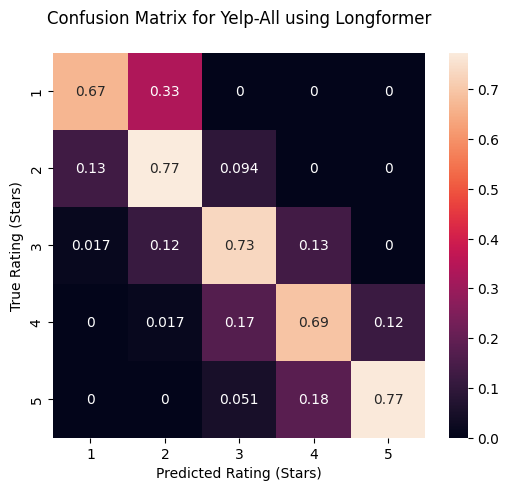

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = yelp_confusion_matrix
df_cm = pd.DataFrame(array, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (6,5))
plt.xlabel('asd')
s = sn.heatmap(df_cm, annot=True)
s.set(xlabel='Predicted Rating (Stars)', ylabel='True Rating (Stars)', title="Confusion Matrix for Yelp-All using Longformer\n")

In [ ]:
from sklearn.metrics import classification_report
target_names = ['1 Star','2 Star','3 Star','4 Star','5 Star']
print(classification_report(actual, array2, target_names=target_names))

              precision    recall  f1-score   support

      1 Star       0.76      0.67      0.71        500
      2 Star       0.66      0.77      0.71        500
      3 Star       0.72      0.73      0.73        500
      4 Star       0.73      0.69      0.71        500
      5 Star       0.81      0.77      0.79        500

    accuracy                           0.73       2500
   macro avg       0.74      0.73      0.73       2500
weighted avg       0.73      0.73      0.73       2500

